In [23]:
!pip install pyspark
!pip install nltk
!pip install wordcloud

In [24]:
import gdown
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession

In [25]:
file_id = '1w2c49UUWnZHbWZ_ryKaWGhIzSF7QuvYJ'
url = f'https://drive.google.com/uc?id={file_id}'
output_path = '/content/mental_health.csv'
if not os.path.exists(output_path):
    gdown.download(url, output_path, quiet=False)
else:
    print(f"The file '{output_path}' already exists.")

The file '/content/mental_health.csv' already exists.


In [26]:
spark = SparkSession.builder.getOrCreate()
spark = SparkSession.builder\
        .master("local")\
        .appName("RDD")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

spark
sc = spark.sparkContext
sc.setCheckpointDir('checkpoint/')

In [27]:
pandas_df = pd.read_csv(output_path)
pandas_df.head()

,text,label
0,dear american teens question dutch person hear...,0
1,nothing look forward lifei dont many reasons k...,1
2,music recommendations im looking expand playli...,0
3,im done trying feel betterthe reason im still ...,1
4,worried year old girl subject domestic physic...,1


In [28]:
from pyspark.sql.types import StructType, StructField, IntegerType, DoubleType, StringType

schema = StructType([
    StructField("text", StringType(), True),
    StructField("label", IntegerType(), True)
])

df = spark.createDataFrame(pandas_df, schema=schema)

In [29]:
df.show(5)

+--------------------+-----+
|                text|label|
+--------------------+-----+
|dear american tee...|    0|
|nothing look forw...|    1|
|music recommendat...|    0|
|im done trying fe...|    1|
|worried  year old...|    1|
+--------------------+-----+
only showing top 5 rows



In [30]:
# Display summary statistics for numerical columns
df.describe().show()

# Display the schema of the DataFrame
df.printSchema()

+-------+--------------------+-------------------+
|summary|                text|              label|
+-------+--------------------+-------------------+
|  count|               27977|              27977|
|   mean|                NULL|0.49462058119169316|
| stddev|                NULL|  0.499979996649814|
|    min|                    |                  0|
|    max|zoomposting real ...|                  1|
+-------+--------------------+-------------------+

root
 |-- text: string (nullable = true)
 |-- label: integer (nullable = true)



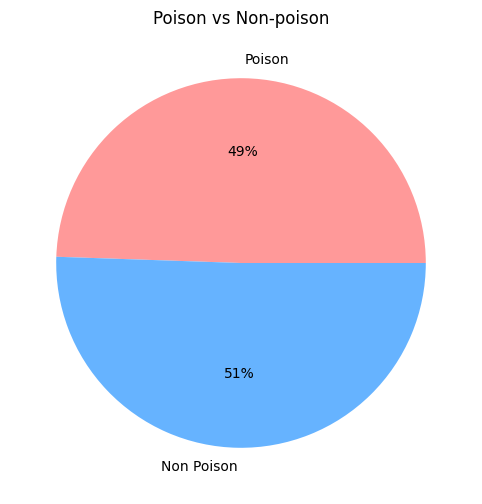

In [31]:
from pyspark.sql.functions import col

# Assuming 'label' is a boolean column in your DataFrame
sarcastic_counts = df.groupBy("label").count().collect()

# Extract counts
non_sarcastic_count = sarcastic_counts[0]["count"]
sarcastic_count = sarcastic_counts[1]["count"]

# Prepare data for pie chart
labels = ['Poison', 'Non Poison']
sizes = [non_sarcastic_count, sarcastic_count]
colors = ['#ff9999', '#66b3ff']

# Plot pie chart
plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, autopct='%1.0f%%', colors=colors)
plt.title('Poison vs Non-poison')

# Display the pie chart
plt.show()


In [32]:
df.show(5)

+--------------------+-----+
|                text|label|
+--------------------+-----+
|dear american tee...|    0|
|nothing look forw...|    1|
|music recommendat...|    0|
|im done trying fe...|    1|
|worried  year old...|    1|
+--------------------+-----+
only showing top 5 rows



In [33]:
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType
import re

def extract_text(text):
    # Add more patterns as needed
    patterns = {
      r"\bim\b": "i am",
      r"\byoure\b": "you are",
      r"\bhes\b": "he is",
      r"\bshes\b": "she is",
      r"\bwere\b": "we are",
      r"\btheyre\b": "they are",
      r"\bive\b": "i have",
      r"\byouve\b": "you have",
      r"\bweve\b": "we have",
      r"\btheyve\b": "they have",
      r"\bwasnt\b": "was not",
      r"\bwont\b": "will not",
      r"\bcant\b": "cannot",
      r"\bdont\b": "do not",
      r"\bdoesnt\b": "does not",
      r"\bdidnt\b": "did not",
      r"\bhavent\b": "have not",
      r"\bhasnt\b": "has not",
      r"\bhadnt\b": "had not",
      r"\barent\b": "are not",
      r"\bwerent\b": "were not",
      r"\bisnt\b": "is not",
      r"\byoull\b": "you will",
      r"\bwell\b": "we will",
      r"\btheyll\b": "they will",
      r"\bill\b": "i will",
      r"\bhell\b": "he will",
      r"\bshell\b": "she will",
      r"\bitll\b": "it will",
      r"\bshed\b": "she would",
      r"\bhed\b": "he would",
      r"\bid\b": "i would",
      r"\byoud\b": "you would",
      r"\bwed\b": "we would",
      r"\btheyd\b": "they would",
      r"\bcouldve\b": "could have",
      r"\bshouldve\b": "should have",
      r"\bwouldve\b": "would have",
      r"\bwhos\b": "who is",
      r"\bwhats\b": "what is",
      r"\bwheres\b": "where is",
      r"\bwhens\b": "when is",
      r"\bwhys\b": "why is",
      r"\bhows\b": "how is",
      r"\bwhod\b": "who would",
      r"\bwhatd\b": "what would",
      r"\bwhered\b": "where would",
      r"\bwhend\b": "when would",
      r"\bwhyd\b": "why would",
      r"\bhowd\b": "how would",
      r"\bwholl\b": "who will",
      r"\bwhatll\b": "what will",
      r"\bwherell\b": "where will",
      r"\bwhenll\b": "when will",
      r"\bwhyll\b": "why will",
      r"\bhowll\b": "how will",
      r"\bwhore\b": "who are",
      r"\bwhatre\b": "what are",
      r"\bwherere\b": "where are",
      r"\bwhenre\b": "when are",
      r"\bwhyre\b": "why are",
      r"\bhowre\b": "how are",
      r"\bthats\b": "that is",
      r"\bthiss\b": "this is",
      r"\btheres\b": "there is",
      r"\bheres\b": "here is",
      r"\bits\b": "it is",
      r"\bwhove\b": "who have",
      r"\bwhatve\b": "what have",
      r"\bwhereve\b": "where have",
      r"\bwhenve\b": "when have",
      r"\bwhyve\b": "why have",
      r"\bhowve\b": "how have",
      r"\bimma\b": "i am going to",
      r"\bgonna\b": "going to",
      r"\bgotta\b": "got to",
      r"\bwanna\b": "want to",
      r"\bhafta\b": "have to",
      r"\bkinda\b": "kind of",
      r"\bsorta\b": "sort of",
      r"\blemme\b": "let me",
      r"\boutta\b": "out of",
      r"\bgotcha\b": "got you",
      # add more contractions and their expanded forms
    }

    # Function to apply substitution to each token in the array
    def process_token(token):
       for pattern, replacement in patterns.items():
           token = re.sub(pattern, replacement, token)
       return token

    processed_text = process_token(text)

    return processed_text


# Register the function as a UDF (User Defined Function)
extract_text_udf = udf(extract_text, StringType())

# Apply the UDF to the 'filtered_words' column (or the column you want to extract text from)
df = df.withColumn('extracted_text', extract_text_udf('text'))


In [34]:
# Show the updated DataFrame
df.show(15)

+--------------------+-----+--------------------+
|                text|label|      extracted_text|
+--------------------+-----+--------------------+
|dear american tee...|    0|dear american tee...|
|nothing look forw...|    1|nothing look forw...|
|music recommendat...|    0|music recommendat...|
|im done trying fe...|    1|i am done trying ...|
|worried  year old...|    1|worried  year old...|
|hey rredflag sure...|    1|hey rredflag sure...|
|feel like someone...|    0|feel like someone...|
|deserve liveif di...|    1|deserve liveif di...|
|feels good ive se...|    1|feels good i have...|
|live guiltok made...|    1|live guiltok made...|
|excercise motivat...|    0|excercise motivat...|
|know youd rather ...|    0|know you would ra...|
|even time fuck  s...|    0|even time fuck  s...|
|usual hollywood s...|    0|usual hollywood s...|
|think it nearly u...|    0|think it nearly u...|
+--------------------+-----+--------------------+
only showing top 15 rows



In [35]:
from pyspark.ml.feature import StopWordsRemover, Tokenizer

tokenizer = Tokenizer(inputCol="extracted_text", outputCol="tokened")
df = tokenizer.transform(df)

In [36]:
df.show(15)

+--------------------+-----+--------------------+--------------------+
|                text|label|      extracted_text|             tokened|
+--------------------+-----+--------------------+--------------------+
|dear american tee...|    0|dear american tee...|[dear, american, ...|
|nothing look forw...|    1|nothing look forw...|[nothing, look, f...|
|music recommendat...|    0|music recommendat...|[music, recommend...|
|im done trying fe...|    1|i am done trying ...|[i, am, done, try...|
|worried  year old...|    1|worried  year old...|[worried, , year,...|
|hey rredflag sure...|    1|hey rredflag sure...|[hey, rredflag, s...|
|feel like someone...|    0|feel like someone...|[feel, like, some...|
|deserve liveif di...|    1|deserve liveif di...|[deserve, liveif,...|
|feels good ive se...|    1|feels good i have...|[feels, good, i, ...|
|live guiltok made...|    1|live guiltok made...|[live, guiltok, m...|
|excercise motivat...|    0|excercise motivat...|[excercise, motiv...|
|know 

In [37]:
import nltk
nltk.download('stopwords')
stopwords_remover = StopWordsRemover(inputCol="tokened", outputCol="filtered")

# Fit and transform the DataFrame
df = stopwords_remover.transform(df)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [38]:
df.show(15)

+--------------------+-----+--------------------+--------------------+--------------------+
|                text|label|      extracted_text|             tokened|            filtered|
+--------------------+-----+--------------------+--------------------+--------------------+
|dear american tee...|    0|dear american tee...|[dear, american, ...|[dear, american, ...|
|nothing look forw...|    1|nothing look forw...|[nothing, look, f...|[nothing, look, f...|
|music recommendat...|    0|music recommendat...|[music, recommend...|[music, recommend...|
|im done trying fe...|    1|i am done trying ...|[i, am, done, try...|[done, trying, fe...|
|worried  year old...|    1|worried  year old...|[worried, , year,...|[worried, , year,...|
|hey rredflag sure...|    1|hey rredflag sure...|[hey, rredflag, s...|[hey, rredflag, s...|
|feel like someone...|    0|feel like someone...|[feel, like, some...|[feel, like, some...|
|deserve liveif di...|    1|deserve liveif di...|[deserve, liveif,...|[deserve, 

In [40]:
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from pyspark.sql.functions import udf, transform

nltk.download('wordnet')

def penn2morphy(penntag):
   """ Converts Penn Treebank tags to WordNet. """
   morphy_tag = {'NN':'n', 'JJ':'a', 'VB':'v', 'RB':'r'}
   try:
       return morphy_tag[penntag[:2]]
   except:
       return 'n'

def lemmatize(words):
   lemmatizer = WordNetLemmatizer()
   return [lemmatizer.lemmatize(word.lower(), pos=penn2morphy(tag))
           for word, tag in pos_tag(words)]

lemmatize_udf = udf(lemmatize, ArrayType(StringType()))

df = df.withColumn('lemmatized', lemmatize_udf(df['filtered']))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [41]:
df.show(20)

+--------------------+-----+--------------------+--------------------+--------------------+--------------------+
|                text|label|      extracted_text|             tokened|            filtered|          lemmatized|
+--------------------+-----+--------------------+--------------------+--------------------+--------------------+
|dear american tee...|    0|dear american tee...|[dear, american, ...|[dear, american, ...|[dear, american, ...|
|nothing look forw...|    1|nothing look forw...|[nothing, look, f...|[nothing, look, f...|[nothing, look, f...|
|music recommendat...|    0|music recommendat...|[music, recommend...|[music, recommend...|[music, recommend...|
|im done trying fe...|    1|i am done trying ...|[i, am, done, try...|[done, trying, fe...|[do, try, feel, b...|
|worried  year old...|    1|worried  year old...|[worried, , year,...|[worried, , year,...|[worry, , year, o...|
|hey rredflag sure...|    1|hey rredflag sure...|[hey, rredflag, s...|[hey, rredflag, s...|[hey,

In [42]:
from pyspark.ml.feature import HashingTF, IDF, Tokenizer

hashingTF = HashingTF(inputCol="lemmatized", outputCol="rawFeatures", numFeatures=1000)
df = hashingTF.transform(df)

idf = IDF(inputCol="rawFeatures", outputCol="features")
idfModel = idf.fit(df)
df = idfModel.transform(df)

In [43]:
df.show(5)

+--------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|                text|label|      extracted_text|             tokened|            filtered|          lemmatized|         rawFeatures|            features|
+--------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|dear american tee...|    0|dear american tee...|[dear, american, ...|[dear, american, ...|[dear, american, ...|(1000,[94,249,326...|(1000,[94,249,326...|
|nothing look forw...|    1|nothing look forw...|[nothing, look, f...|[nothing, look, f...|[nothing, look, f...|(1000,[53,115,133...|(1000,[53,115,133...|
|music recommendat...|    0|music recommendat...|[music, recommend...|[music, recommend...|[music, recommend...|(1000,[15,70,82,8...|(1000,[15,70,82,8...|
|im done trying fe...|    1|i am done trying ...|[i, am, done, try...|

In [44]:
df = df.drop('tokened')
df = df.drop('filtered')
df = df.drop('lemmatized')
df = df.drop('extracted_text')

In [45]:
df.show(5)

+--------------------+-----+--------------------+--------------------+
|                text|label|         rawFeatures|            features|
+--------------------+-----+--------------------+--------------------+
|dear american tee...|    0|(1000,[94,249,326...|(1000,[94,249,326...|
|nothing look forw...|    1|(1000,[53,115,133...|(1000,[53,115,133...|
|music recommendat...|    0|(1000,[15,70,82,8...|(1000,[15,70,82,8...|
|im done trying fe...|    1|(1000,[69,87,114,...|(1000,[69,87,114,...|
|worried  year old...|    1|(1000,[0,7,15,16,...|(1000,[0,7,15,16,...|
+--------------------+-----+--------------------+--------------------+
only showing top 5 rows



In [46]:
(train, test) = df.randomSplit([0.8,0.2])

In [47]:
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
gb = GBTClassifier(labelCol = 'label', featuresCol = 'features')
gbModel = gb.fit(train)
gb_predictions = gbModel.transform(test)

In [48]:
gb_predictions.show(5)

+--------------------+-----+--------------------+--------------------+--------------------+--------------------+----------+
|                text|label|         rawFeatures|            features|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+--------------------+--------------------+----------+
|                    |    0|        (1000,[],[])|        (1000,[],[])|[0.84071643292209...|[0.84309417295924...|       0.0|
|                    |    1|        (1000,[],[])|        (1000,[],[])|[0.84071643292209...|[0.84309417295924...|       0.0|
|  floorstheres ap...|    1|(1000,[17,44,126,...|(1000,[17,44,126,...|[1.05541017948121...|[0.89195042064984...|       0.0|
|  im still horndo...|    0|(1000,[25,179,204...|(1000,[25,179,204...|[0.89701560037038...|[0.85742080272262...|       0.0|
|  literally grow ...|    0|(1000,[372,404,41...|(1000,[372,404,41...|[0.87098807973272...|[0.85093790052875...|       0.0|
+-------

In [49]:
multi_evaluator = MulticlassClassificationEvaluator(labelCol = 'label', metricName = 'accuracy')
print('Accuracy:', multi_evaluator.evaluate(gb_predictions))

Accuracy: 0.8234979497236584


In [50]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline

In [51]:
# Function to predict mental health without pipelineFit.transform(input_df)
def predict_mental_health_spark(features_df):
    # Make the prediction
    prediction = gbModel.transform(features_df)

    # Assuming the prediction column is named 'prediction'
    result = prediction.select("prediction").collect()[0]["prediction"]
    return int(result)

In [52]:
# Manual Input and Prediction
user_input = input("Enter a text to predict if it contains mental health or not: ")

# Assuming you've already tokenized, hashed, and applied TF-IDF to the user_input
user_features_df = df  # Your preprocessed features dataframe

prediction = predict_mental_health_spark(user_features_df)

if prediction == 1:
    print("The input suggests positive mental health.")
else:
    print("The input suggests negative mental health")


Enter a text to predict if it contains mental health or not: eat sleep gaming
The input suggests negative mental health
